In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
%matplotlib inline

### Task 1: Data Preparation
Divide the Dataset into Train and Test Sets:
- Load the Kaggle Housing Prices dataset.
- Perform an initial assessment of the dataset to understand its structure and features.
- Split the dataset into training (70%) and testing (30%) sets using a random seed for reproducibility.

In [2]:
# Read CSV to Pandas DataFrame and display top 5 rows
df = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# for col in df.columns.drop(['Id', 'SalePrice']):
#     plt.figure(figsize=(20, 6))
#     plt.title(f'{col}', fontdict={'size': 15})
#     sns.histplot(data=df[col], bins=100)
#     plt.show()
    
#     plt.figure(figsize=(20, 6))
#     sns.boxplot(data=df[col])
#     plt.show()
    
#     plt.figure(figsize=(20, 6))
#     sns.scatterplot(x=df[col], y=df['SalePrice'])
#     plt.show()

In [4]:
# Split data into features and traget
features = df.drop(['Id', 'SalePrice'], axis=1)
target = df['SalePrice']

# Split features and target into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

### Task 2: Building a Basic Random Forest Model
Create a Random Forest Model with Numerical Features:
- Identify and isolate the numerical features from the dataset.
- Remove any rows with null values in these numerical columns to ensure data integrity.
- Train a Random Forest model on the training set using only these non-null numerical features.
- Evaluate the model's performance on the test set using the MSE metrics.

In [5]:
# Isolate numerical columns from other feature columns
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Remove 'MSSubClass' from numerical columns because it is actually categorical
numerical_cols.remove('MSSubClass')

# Number of numerical features
len(numerical_cols)

35

In [6]:
# Check if numerical columns have null values in them
X_train[numerical_cols].isna().sum()

LotFrontage      189
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         5
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       54
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [7]:
# Check if training target has null values
y_train.isnull().sum()

0

In [8]:
# Find indices of null values
X_train_numerical = X_train[numerical_cols]

missing_value_index = X_train_numerical[X_train_numerical.isna().any(axis=1)].index

# Drop rows with missing values from numerical training data
X_train_numerical_clean = X_train_numerical.drop(missing_value_index)

# drop the same rows from the training target column
y_train_clean = y_train.drop(missing_value_index)

In [9]:
# Construct a Random Forest model
num_base_model = RandomForestRegressor(random_state=46, n_estimators=100)

# Train the model with numerical features
num_base_model.fit(X=X_train_numerical_clean, y=y_train_clean)

# Drop rows with null values from test data
X_test_numerical = X_test[numerical_cols]
missing_value_index_test = X_test_numerical[X_test_numerical.isna().any(axis=1)].index
X_test_numerical_clean = X_test_numerical.drop(missing_value_index_test)
y_test_clean = y_test.drop(missing_value_index_test)

# Predict 'SalePrice'
y_pred = num_base_model.predict(X_test_numerical_clean)

In [10]:
# Evaluate model performance via MSE
mse_numerical = mean_squared_error(y_pred=y_pred, y_true=y_test_clean)
print(f"MSE for RF model with only numerical features: {mse_numerical}")

MSE for RF model with only numerical features: 1187413587.261595


### Task 3: Building an Enhanced Random Forest Model
Data Preprocessing for Categorical Features:
- Identify categorical features in the dataset.
- Convert these categorical features into dummy variables using one-hot encoding (e.g., pd.get_dummies).
- Ensure that dummy variable creation is consistent between train and test sets.

Handling Null Values:
- For both numerical and categorical data, fill in missing values.
- Choose an appropriate strategy for filling nulls (e.g., mean or median for numerical, mode or a placeholder for categorical).

Training the Full Model:
- Train a Random Forest model on the training set, this time using both the numerical and encoded categorical features.
- Again, assess the model's performance on the test set.

In [11]:
categorical_cols = X_train.columns.drop(numerical_cols)
categorical_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [12]:
X_train_categorical = X_train[categorical_cols]

# Check for null values
X_train_categorical.isna().sum()

MSSubClass          0
MSZoning            0
Street              0
Alley             960
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        614
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           24
BsmtCond           24
BsmtExposure       24
BsmtFinType1       24
BsmtFinType2       25
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       478
GarageType         54
GarageFinish       54
GarageQual         54
GarageCond         54
PavedDrive          0
PoolQC           1019
Fence             831
MiscFeature       978
SaleType            0
SaleCondition       0
dtype: int64

In [13]:
# Get names of columns with more than 800 missing values
almost_empty_cols = X_train_categorical.columns[X_train_categorical.isna().sum() > 800]

# Delete these columns from categorical columns
categorical_cols.drop(almost_empty_cols)

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [14]:
# Custom transformer for dynamic renaming after One-Hot-Encoding to include original column name
# class DynamicColumnRenamer(BaseEstimator, TransformerMixin):
#     def __init__(self, original_feature_names):
#         self.original_feature_names = original_feature_names

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         # Assume X is output of OneHotEncoder with handle_unknown='ignore'
#         encoded_feature_names = X.get_feature_names_out(self.original_feature_names)
#         return pd.DataFrame(X, columns=encoded_feature_names)

In [15]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing of categorical data
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', one_hot),
    # ('rename', DynamicColumnRenamer(categorical_cols))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols)
    ]
)

# Define a Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Full data pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

In [16]:
# Training the enhanced model
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  SimpleImputer(strategy='median'),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'FullBath',
                                                   'Half...
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [17]:
y_pred = rf_pipeline.predict(X_test)

In [18]:
mse_enhanced = mean_squared_error(y_pred=y_pred, y_true=y_test)
print(f"MSE for enhanced RF model: {mse_enhanced}")

MSE for enhanced RF model: 1019122446.6698642


Feature Importance Analysis:
- Calculate and analyze feature importance from the Random Forest model.
- Decide on the top X features to use for a more streamlined model. Consider different thresholds like top 30, 100, and 200 features based on their importance.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


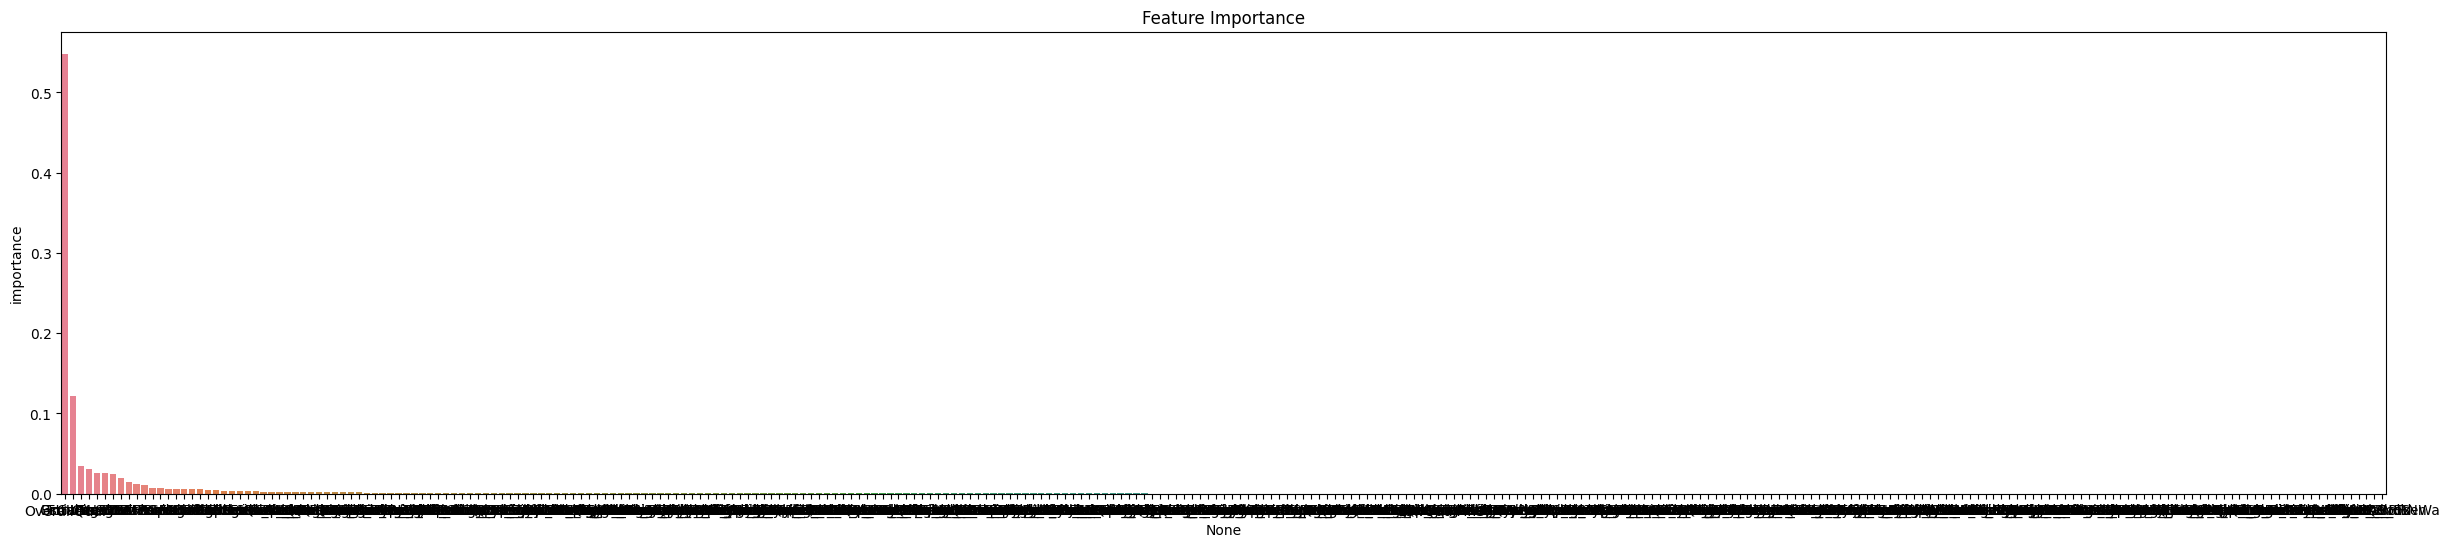

In [65]:
# Accessing 'Helpful_ml_functions' directory
%load_ext autoreload
from transformer_features import get_feature_names

# Get model object from pipeline
model = rf_pipeline.named_steps['model']

# Get feature_importances from model
importances = model.feature_importances_

# Get ColumnTransformer (preprocessor) from pipeline
rf_preprocessor = rf_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = get_feature_names(rf_preprocessor)

# Create feature importance DataFrame
feature_importance = pd.DataFrame(data=importances, index=feature_names, columns=['importance'])

# Sort DataFrame by importance in descending order
feature_importance_sorted = feature_importance.sort_values(by='importance', ascending=False)

# Display full set of importances
plt.figure(figsize=(30, 6))
plt.title("Feature Importance")
sns.barplot(x=feature_importance_sorted.index, y=feature_importance_sorted['importance'], hue=feature_importance_sorted.index)
plt.show()